# Import

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import itertools
import keras
import keras_tuner as kt
import xgboost as xgb

from random import gauss
from random import seed

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, root_mean_squared_error,r2_score

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from arch import arch_model

from pmdarima import auto_arima
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from keras_tuner import Hyperband
from keras.models import load_model,Sequential

In [3]:
df = pd.read_csv('../data/cleaned_data/master.csv',index_col=0)
df.head()

,nonglu_price,hommali_price,agri_prod_index,crops_prod_index,paddy_prod_index,nonglu_prod_index,hommali_prod_index,agri_price_index,crops_price_index,paddy_price_index,...,water_station_M7,water_station_N1,water_station_N67,water_station_Ny1B,water_station_P1,water_station_P17,water_station_S4B,water_station_Sw5A,water_station_Y17,water_station_Y1C
date,,,,,,,,,,,,,,,,,,,,,
2006-01-01,6696.0,7628.0,109.703894,114.011647,43.580672,72.649707,8.077559,110.377654,113.821771,100.581118,...,140.50,66.17,520.00,26.85,38.96,679.63,6.23,97.92,1.24,20.25
2006-02-01,6633.0,7873.0,93.049409,91.755084,46.062229,85.832560,0.000000,111.337228,115.390439,101.563145,...,87.75,39.02,501.32,26.22,64.11,573.91,4.69,69.55,0.00,13.07
2006-03-01,6649.0,7960.0,92.803780,87.828340,74.516499,138.854375,0.000000,112.498075,117.876876,103.063764,...,108.95,20.94,558.72,42.23,68.26,523.38,2.23,60.02,2.32,35.51
2006-04-01,6880.0,8028.0,75.452369,67.662286,66.215260,123.385807,0.000000,115.595159,121.878356,104.906097,...,188.40,45.73,692.79,61.08,84.68,508.65,0.06,76.80,5.84,31.54
2006-05-01,6782.0,8069.0,77.366260,68.992476,35.785484,66.682829,0.000000,113.408937,119.725058,104.687875,...,270.30,94.19,1027.25,44.98,146.19,1092.68,34.64,88.76,168.17,268.37


In [4]:
# Set index as datetime
df.index = pd.to_datetime(df.index,format="%Y-%m-%d")

In [5]:
# Check type of value
df.dtypes.value_counts()

float64    49
Name: count, dtype: int64

In [6]:
df.shape

(226, 49)

# Model

In [8]:
# Create the target
y = df['nonglu_price']

# Define independent variables (predictors) X
xvars_prod_index = ['agri_prod_index', 'crops_prod_index',
                    'paddy_prod_index', 'nonglu_prod_index', 'hommali_prod_index']

# Adjust X to match the same periods
X = df[xvars_prod_index]

In [9]:
# Split data into training and test sets
# shuffle=False maintains time order (crucial for time series!)
# test_size=20 reserves last 20 observations for testing

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=25)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((201, 5), (25, 5), (201,), (25,))

In [10]:
X_train['shock_event_1'] = [1 if date >= pd.to_datetime('2008-01-01') else 0 for date in y_train.index]
X_test['shock_event_1'] = [1 if date >= pd.to_datetime('2008-01-01')  else 0 for date in y_test.index]

X_train['shock_event_2'] = [1 if date >= pd.to_datetime('2008-04-01') else 0 for date in y_train.index]
X_test['shock_event_2'] = [1 if date >= pd.to_datetime('2008-04-01')  else 0 for date in y_test.index]

X_train['shock_event_3'] = [1 if date >= pd.to_datetime('2022-07-01') else 0 for date in y_train.index]
X_test['shock_event_3'] = [1 if date >= pd.to_datetime('2022-07-01')  else 0 for date in y_test.index]

X_train['shock_event_4'] = [1 if date >= pd.to_datetime('2024-09-01') else 0 for date in y_train.index]
X_test['shock_event_4'] = [1 if date >= pd.to_datetime('2024-09-01')  else 0 for date in y_test.index]


# If the sharp drop can be explained through existing exogenous variables or lagged 
# effects, a shock variable may not add significant predictive value.
# If the drop reflects a unique, external event, the shock variable might be the key 
# to improving forecasts.

## 1. Linear Regression Model

### Model 1: Linear Regression Model

In [13]:
label = 'nonglu_price'
df = df[xvars_prod_index + [label]]

train_data = df[df.index < '2022-10-01']
test_data = df[df.index >= '2022-10-01']

X_train = train_data.drop(columns=['nonglu_price'])
y_train = train_data['nonglu_price']

X_test = test_data.drop(columns=['nonglu_price'])
y_test = test_data['nonglu_price']

In [14]:
X_train['shock_event_1'] = [1 if date >= pd.to_datetime('2008-01-01') else 0 for date in y_train.index]
X_test['shock_event_1'] = [1 if date >= pd.to_datetime('2008-01-01')  else 0 for date in y_test.index]

X_train['shock_event_2'] = [1 if date >= pd.to_datetime('2008-04-01') else 0 for date in y_train.index]
X_test['shock_event_2'] = [1 if date >= pd.to_datetime('2008-04-01')  else 0 for date in y_test.index]

X_train['shock_event_3'] = [1 if date >= pd.to_datetime('2022-07-01') else 0 for date in y_train.index]
X_test['shock_event_3'] = [1 if date >= pd.to_datetime('2022-07-01')  else 0 for date in y_test.index]

X_train['shock_event_4'] = [1 if date >= pd.to_datetime('2024-09-01') else 0 for date in y_train.index]
X_test['shock_event_4'] = [1 if date >= pd.to_datetime('2024-09-01')  else 0 for date in y_test.index]


# If the sharp drop can be explained through existing exogenous variables or lagged 
# effects, a shock variable may not add significant predictive value.
# If the drop reflects a unique, external event, the shock variable might be the key 
# to improving forecasts.

In [15]:
# Instantiate and fit an Linear model
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [16]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((201, 9), (25, 9), (201,), (25,))

In [17]:
# Prediction
y_pred = lr.predict(X_test)

In [18]:
# Evaluate the Linear Regression Model
lr_mse = mean_squared_error(y_test, y_pred)
lr_rmse = root_mean_squared_error(y_test, y_pred)
lr_r2 = r2_score(y_test, y_pred)

print(f"Linear Regression Model MSE: {lr_mse:.4f}")
print(f"Linear Regression Model RMSE: {lr_rmse:.4f}")
print(f"Linear Regression Model R-squared: {lr_r2:.4f}")

Linear Regression Model MSE: 4310484.5008
Linear Regression Model RMSE: 2076.1706
Linear Regression Model R-squared: -2.9195


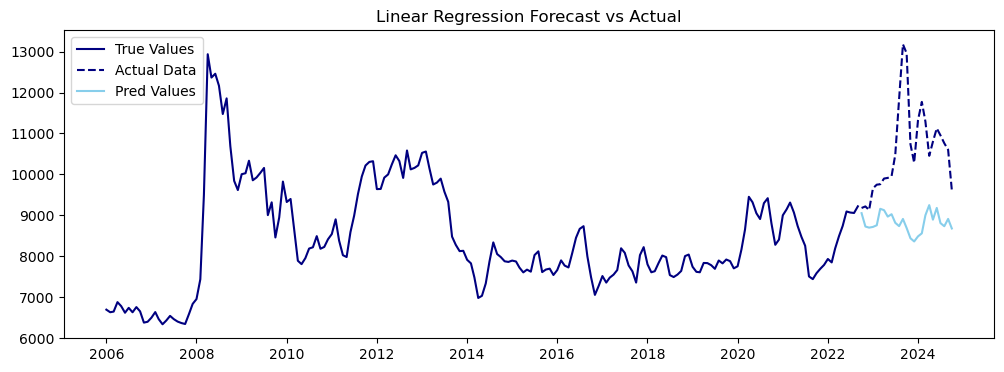

In [19]:
# Plot predictions
plt.figure(figsize=(12, 4))
plt.plot(y_train, c='navy', label='True Values')
plt.plot(y_test, c='navy', linestyle='dashed', label="Actual Data")
plt.plot(test_data.index,y_pred, c='skyblue', label='Pred Values')
plt.title("Linear Regression Forecast vs Actual")
plt.legend()

# saving the plot as an image
plt.savefig('../figure/production_index/Linear Regression Forecast vs Actual.png')
plt.show()

#### Feature importance

In [21]:
#print regression coefficients
pd.DataFrame(zip(X.columns, lr.coef_))

,0,1
0,agri_prod_index,-84.949075
1,crops_prod_index,51.275885
2,paddy_prod_index,13.257736
3,nonglu_prod_index,-6.154264
4,hommali_prod_index,-3.589602


## 2. ARIMA Model

### Model 2 : ARIMA

In [24]:
# Fit an ARIMA model with exogenous variables (also called ARIMAX)
y_train.index.freq = 'MS'
X_train.index.freq = 'MS'

arimax1_model = ARIMA(
    y_train,                 # Dependent variable (nonglu_price)
    exog=X_train,            # External variables 
    order=(2, 1, 2)).fit()   # ARIMA parameters: (p=2, d=1, q=2)

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [25]:
# Generate predictions on the test set
arimax1_forecast = arimax1_model.predict(
   start=X_test.index[0],    # Start forecasting from first test observation
   end=X_test.index[-1],     # Continue until last test observation
   exog=X_test)

In [26]:
# Evaluate the ARIMAX(2,1,2) Model
arimax1_mse = mean_squared_error(y_test, arimax1_forecast)
arimax1_rmse = root_mean_squared_error(y_test, arimax1_forecast)
arimax1_r2 = r2_score(y_test, arimax1_forecast)

print(f"ARIMAX(2,1,2) Model MSE : {arimax1_mse:.4f}")
print(f"ARIMAX(2,1,2) Model RMSE :{arimax1_rmse:.4f}")
print(f"ARIMAX(2,1,2) Model R-squared :{arimax1_r2:.4f}")

ARIMAX(2,1,2) Model MSE : 2983559.1674
ARIMAX(2,1,2) Model RMSE :1727.2982
ARIMAX(2,1,2) Model R-squared :-1.7129


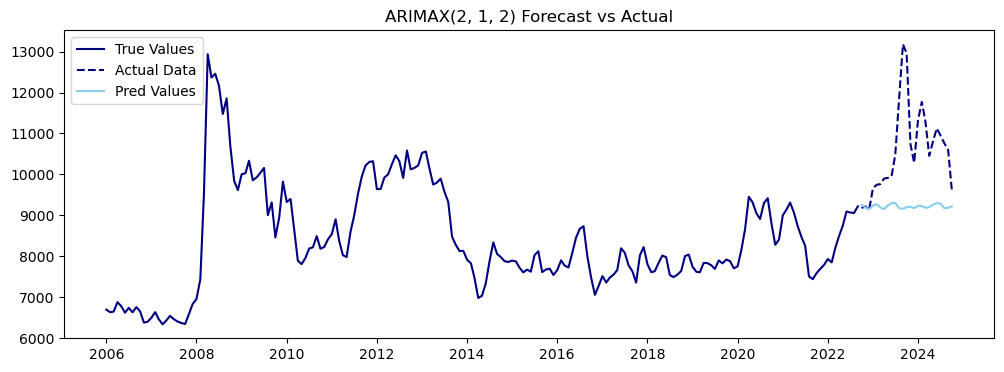

In [27]:
# Plot 
plt.figure(figsize=(12, 4))
plt.plot(y_train, c='navy', label='True Values')
plt.plot(y_test, c='navy', linestyle='dashed', label="Actual Data")
plt.plot(arimax1_forecast, c='skyblue', label='Pred Values')
plt.title("ARIMAX(2, 1, 2) Forecast vs Actual")
plt.legend()

# saving the plot as an image
plt.savefig('../figure/production_index/ARIMAX(2,1,2) Forecast vs Actual.png')
plt.show()

#### Feature Importance

In [29]:
arimax1_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           nonglu_price   No. Observations:                  201
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1455.052
Date:                Thu, 19 Dec 2024   AIC                           2938.105
Time:                        14:21:39   BIC                           2984.281
Sample:                    01-01-2006   HQIC                          2956.792
                         - 09-01-2022                                         
Covariance Type:                  opg                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
agri_prod_index       -2.9158     14.167     -0.206      0.837     -30.683      24.852
crops_prod_index       1.0710     10.355      0.103      0.918     -19.224      21.366
paddy_prod_index       1.7469      2.451      0.713      0.476      -3.057       6.551
nonglu_prod_index     -1.6085      1.509     -1.066      0.287      -4.567       1.350
hommali_prod_index    -0.4562      0.955     -0.478      0.633      -2.327       1.415
shock_event_1         94.1299   1528.851      0.062      0.951   -2902.363    3090.623
shock_event_2       3527.1638    432.799      8.150      0.000    2678.894    4375.434
shock_event_3        -18.2306   7119.880     -0.003      0.998    -1.4e+04    1.39e+04
shock_event_4               0      7.148          0      1.000     -14.010      14.010
ar.L1                  0.4493      0.111      4.043      0.000       0.231       0.667
ar.L2                 -0.8462      0.111     -7.651      0.000      -1.063      -0.629
ma.L1                 -0.3231      0.109     -2.969      0.003      -0.536      -0.110
ma.L2                  0.8481      0.128      6.613      0.000       0.597       1.099
sigma2              1.285e+05   1.08e+04     11.887      0.000    1.07e+05     1.5e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):               244.64
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               0.38   Skew:                             0.49
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.24e+23. Standard errors may be unstable.
"""

### Model 3 : Auto ARIMA

In [31]:
# Automatically tune ARIMA parameters
auto_model = auto_arima(
    y_train,exogenous=X_train,
    start_p=0, max_p=4,
    start_q=0, max_q=4,
    d=None,seasonal=False, trace=False,error_action='ignore', suppress_warnings=True, stepwise=True)

# Best parameters
print(auto_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  201
Model:               SARIMAX(2, 0, 0)   Log Likelihood               -1497.527
Date:                Thu, 19 Dec 2024   AIC                           3003.053
Time:                        14:21:39   BIC                           3016.267
Sample:                    01-01-2006   HQIC                          3008.400
                         - 09-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    675.8081    219.037      3.085      0.002     246.504    1105.112
ar.L1          1.2125      0.031     39.511      0.000       1.152       1.273
ar.L2         -0.2931      0.038     -7.801      0.0

In [32]:
# Fit an ARIMA model with exogenous variables (also called ARIMAX)
y_train.index.freq = 'MS'
X_train.index.freq = 'MS'

arimax2_model = ARIMA(
    y_train,           # Dependent variable (nonglu_price)
    exog = X_train,    # External variables 
    order = (2, 0, 0), # ARIMA parameters: (p=2, d=0, q=0)
).fit()

# Get the residual
arimax2_model_residuals = arimax2_model.resid

# Generate predictions on the test set
arimax2_forecast = arimax2_model.predict(
   start=X_test.index[0],    # Start forecasting from first test observation
   end=X_test.index[-1],     # Continue until last test observation
   exog=X_test)

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [33]:
# Evaluate the ARIMAX(2,0,0) Model
arimax2_mse = mean_squared_error(y_test, arimax2_forecast)
arimax2_rmse = root_mean_squared_error(y_test, arimax2_forecast)
arimax2_r2 = r2_score(y_test, arimax2_forecast)

print(f"ARIMAX(2,0,0) Model MSE : {arimax2_mse:.4f}")
print(f"ARIMAX(2,0,0) Model RMSE :{arimax2_rmse:.4f}")
print(f"ARIMAX(2,0,0) Model R-squared :{arimax2_r2:.4f}")

ARIMAX(2,0,0) Model MSE : 1762984.3270
ARIMAX(2,0,0) Model RMSE :1327.7742
ARIMAX(2,0,0) Model R-squared :-0.6031


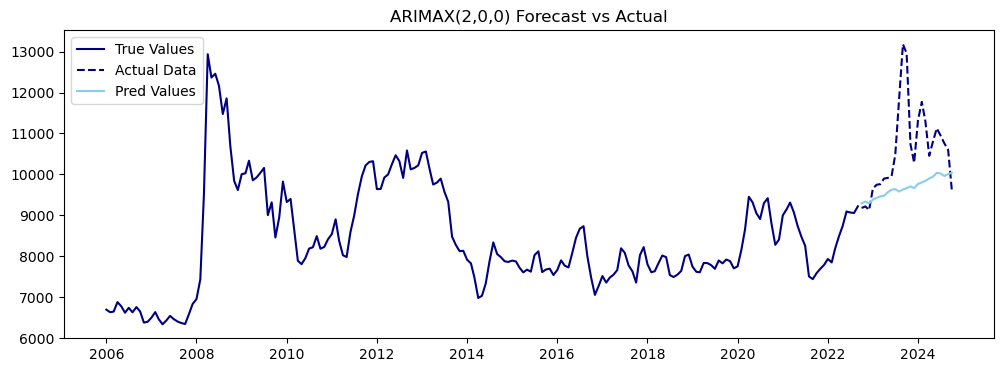

In [34]:
# Plot 
plt.figure(figsize=(12, 4))
plt.plot(y_train, c='navy', label='True Values')
plt.plot(y_test, c='navy', linestyle='dashed', label="Actual Data")
plt.plot(arimax2_forecast, c='skyblue', label='Pred Values')
plt.title("ARIMAX(2,0,0) Forecast vs Actual")
plt.legend()

# saving the plot as an image
plt.savefig('../figure/production_index/ARIMAX(2,0,0) Forecast vs Actual.png')
plt.show()

#### Feature Importance

In [36]:
arimax2_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           nonglu_price   No. Observations:                  201
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -1490.229
Date:                Thu, 19 Dec 2024   AIC                           3006.458
Time:                        14:21:40   BIC                           3049.401
Sample:                    01-01-2006   HQIC                          3023.835
                         - 09-01-2022                                         
Covariance Type:                  opg                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               9945.5325   3739.471      2.660      0.008    2616.304    1.73e+04
agri_prod_index      -10.1089     18.326     -0.552      0.581     -46.027      25.809
crops_prod_index       5.5774     13.342      0.418      0.676     -20.572      31.727
paddy_prod_index       1.3635      3.282      0.415      0.678      -5.069       7.796
nonglu_prod_index     -1.1337      2.057     -0.551      0.582      -5.166       2.898
hommali_prod_index    -0.1865      1.269     -0.147      0.883      -2.674       2.302
shock_event_1       1357.6268    164.165      8.270      0.000    1035.870    1679.384
shock_event_2       1398.0831    227.473      6.146      0.000     952.244    1843.922
shock_event_3        905.5668    200.402      4.519      0.000     512.786    1298.347
shock_event_4               0        nan        nan        nan         nan         nan
ar.L1                  1.1762      0.066     17.709      0.000       1.046       1.306
ar.L2                 -0.1843      0.066     -2.813      0.005      -0.313      -0.056
sigma2               1.74e+05   1.46e+04     11.906      0.000    1.45e+05    2.03e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):               187.65
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):               0.31   Skew:                             0.41
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.02e+28. Standard errors may be unstable.
"""

## 4. GARCH Model

### Model 4 : GARCH

In [39]:
# Seed pseudorandom number generator
seed(1)

# Define model - fit on the residuals.
garch_model = arch_model(arimax2_model_residuals,mean='HARX', vol='GARCH', p=1, q=1, rescale=False)

# Fit model
garch_model_fit = garch_model.fit(disp='off')

# forecast the test set
garch_forecast = garch_model_fit.forecast(horizon=len(y_test), reindex=False)
garch_volatility = np.sqrt(garch_forecast.variance.values[-1])  # Convert to standard deviation

arimax_forecast = arimax2_model.get_forecast(steps=len(y_test), exog=X_test)
arimax_mean = arimax_forecast.predicted_mean

# combine ARIMAX Mean and GARCH Volatility
yhat = arimax_mean + garch_volatility  # Add GARCH volatility directly

In [40]:
# Evaluate the GARCH Model
garch_mse = mean_squared_error(y_test, yhat)
garch_rmse = root_mean_squared_error(y_test, yhat)
garch_r2 = r2_score(y_test, yhat)
print(f"GARCH Model MSE : {garch_mse:.4f}")
print(f"GARCH Model RMSE :{garch_rmse:.4f}")
print(f"GARCH Model R-squared :{garch_r2:.4f}")

GARCH Model MSE : 1144504.3735
GARCH Model RMSE :1069.8151
GARCH Model R-squared :-0.0407


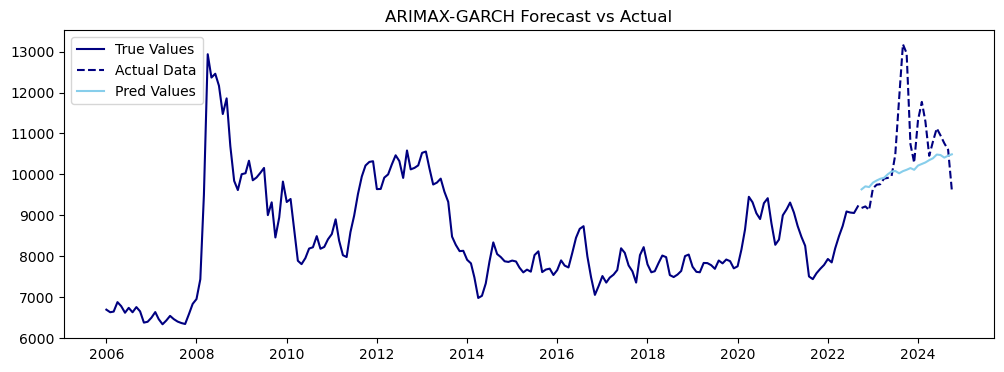

In [41]:
plt.figure(figsize=(12, 4))
plt.plot(y_train, c='navy', label="True Values")
plt.plot(y_test.index, y_test, c='navy', linestyle='dashed', label="Actual Data")
plt.plot(y_test.index, yhat, c='skyblue', label="Pred Values")
plt.legend()
plt.title("ARIMAX-GARCH Forecast vs Actual")

# saving the plot as an image
plt.savefig('../figure/production_index/ARIMAX-GARCH Forecast vs Actual.png')
plt.show()

#### Feature Importance

In [43]:
print('GARCH Coefficients:')
print('omega (constant):', garch_model_fit.params['omega'])
print('alpha (ARCH term):', garch_model_fit.params['alpha[1]'])
print('beta (GARCH term):', garch_model_fit.params['beta[1]'])

GARCH Coefficients:
omega (constant): 57621.52063798651
alpha (ARCH term): 0.5022643522161567
beta (GARCH term): 0.21228472378983637


# Compare the score of models

In [45]:
score_df = pd.DataFrame(data = {'feature' : ['production index'] * 3,
                                'model': ['Linear','ARIMAX(2,0,0)','GARCH'] , 
                                'MSE': [lr_mse,arimax2_mse,garch_mse], 
                                'RMSE': [lr_rmse,arimax2_rmse,garch_rmse], 
                                'R2': [lr_r2,arimax2_r2,garch_r2]})
score_df.to_csv('../data/cleaned_data/evaluation/production_index.csv', index=False)
score_df

,feature,model,MSE,RMSE,R2
0,production index,Linear,4.310485e+06,2076.170634,-2.919518
1,production index,"ARIMAX(2,0,0)",1.762984e+06,1327.774200,-0.603079
2,production index,GARCH,1.144504e+06,1069.815112,-0.040696
